<a href="https://colab.research.google.com/github/fernanda0402/Doutorado/blob/main/GP_gamma_f_sigma_8.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [40]:
# Bibliotecas:

import urllib.request
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
import sympy as sp
import scipy.interpolate as interp
from matplotlib.collections import LineCollection
from matplotlib.colors import ListedColormap, BoundaryNorm
from scipy.optimize import curve_fit
import matplotlib as mpl
mpl.rcParams.update(mpl.rcParamsDefault)
from scipy.integrate import cumtrapz

In [41]:
!pip install -q condacolab
import condacolab
condacolab.install()
!mamba install pyccl

✨🍰✨ Everything looks OK!

                  __    __    __    __
                 /  \  /  \  /  \  /  \
                /    \/    \/    \/    \
███████████████/  /██/  /██/  /██/  /████████████████████████
              /  / \   / \   / \   / \  \____
             /  /   \_/   \_/   \_/   \    o \__,
            / _/                       \_____/  `
            |/
        ███╗   ███╗ █████╗ ███╗   ███╗██████╗  █████╗
        ████╗ ████║██╔══██╗████╗ ████║██╔══██╗██╔══██╗
        ██╔████╔██║███████║██╔████╔██║██████╔╝███████║
        ██║╚██╔╝██║██╔══██║██║╚██╔╝██║██╔══██╗██╔══██║
        ██║ ╚═╝ ██║██║  ██║██║ ╚═╝ ██║██████╔╝██║  ██║
        ╚═╝     ╚═╝╚═╝  ╚═╝╚═╝     ╚═╝╚═════╝ ╚═╝  ╚═╝

        mamba (1.4.1) supported by @QuantStack

        GitHub:  https://github.com/mamba-org/mamba
        Twitter: https://twitter.com/QuantStack

█████████████████████████████████████████████████████████████


Looking for: ['pyccl']

[+] 0.0s
[+] 0.1s
conda-forge/linux-64  ⣾  
conda-forge/noarch  

In [42]:
import pyccl as ccl

In [43]:
!pip install git+https://github.com/JCGoran/GaPP@feature/python3#GaPP
from gapp import gp, covariance
from numpy import loadtxt, savetxt

  Cloning https://github.com/JCGoran/GaPP (to revision feature/python3) to /tmp/pip-req-build-73aemx3x
  Running command git clone --filter=blob:none --quiet https://github.com/JCGoran/GaPP /tmp/pip-req-build-73aemx3x
  Running command git checkout -b feature/python3 --track origin/feature/python3
  Switched to a new branch 'feature/python3'
  Branch 'feature/python3' set up to track remote branch 'feature/python3' from 'origin'.
  Resolved https://github.com/JCGoran/GaPP to commit 931e4d0e0eb861b01c315e960f74b31a9996aa6f
  Preparing metadata (setup.py) ... done


Vamos reconstruir os dados de $f\sigma_8$.

In [44]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).



Optimized hyperparameters:
theta = [0.32366714 4.68947793]


<ipython-input-45-12da56194f50>:41: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "r." (-> color='r'). The keyword argument will take precedence.
  plt.errorbar(x_gapp, y_gapp, e, fmt='r.', color='purple', markersize=10, label='Dados')


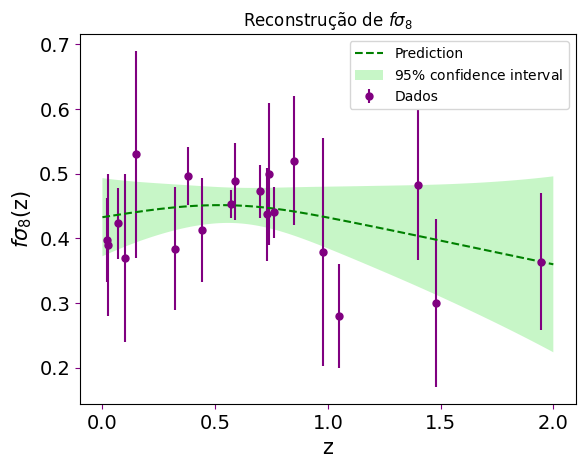

In [45]:
# baixando os dados
data = np.genfromtxt('/content/drive/MyDrive/Doutorado/Dados/fsig8_data.csv', delimiter=', ')

z_dados = data[:, 0]

fs8_dados = data[:, 1]

sig_fs8 = data[:, 2]

# nomeando
x_gapp = z_dados
y_gapp = fs8_dados
e = sig_fs8

# xmin, xmax and nstar are interpreted as two-dimensional vectors
xmin = 0
xmax = 2.0
nstar = 1000

# initial values of the hyperparameters
initheta = [0.4, 0.1]

# initialization of the Gaussian Process
g = gp.GaussianProcess(x_gapp, y_gapp, e, cXstar=(xmin, xmax, nstar),
                       covfunction=covariance.Matern32)

# training of the hyperparameters and reconstruction of the function
(rec, theta) = g.gp(theta=initheta, grad='False')

xi = rec[:, 0]

y_pred = rec[:, 1]
sigma  = rec[:, 2]

y_pred_95_less = y_pred - 1.9600*sigma
y_pred_95_plus = y_pred + 1.9600*sigma

# Plot the function, the prediction and the 95% confidence interval
plt.figure()
plt.tick_params(labelsize=14, color='purple')
plt.errorbar(x_gapp, y_gapp, e, fmt='r.', color='purple', markersize=10, label='Dados')
plt.plot(xi, y_pred, color = 'green', label='Prediction', linestyle="--")
plt.fill(np.concatenate([xi, xi[::-1]]),
         np.concatenate([y_pred - 1.9600 * sigma,
                        (y_pred + 1.9600 * sigma)[::-1]]),
         alpha=.5, color = 'lightgreen', ec='None', label=r'$95\%$ confidence interval')

# legenda, label e título
plt.xlabel('z', fontsize=15)
plt.ylabel('$f\sigma_8$(z)', fontsize=15)
plt.legend(loc='best')
plt.title('Reconstrução de $f\sigma_8$')
plt.show()

# salvando os dados reconstruídos

H = xi, y_pred, sigma
np.savetxt('fs8_recon.dat', np.transpose(H), delimiter='\t')
#from google.colab import files
#files.download("fs8_recon.dat")

Vamos fazer a primeira derivada usando o GaPP de $f\sigma_8$.


Optimized hyperparameters:
theta = [0.32366714 4.68947793]


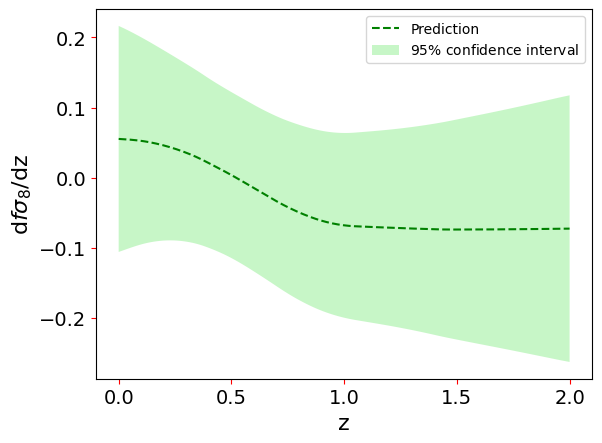

In [46]:
from gapp import dgp # dgp calcula a primeira, segunda e terceira derivada

# baixando os dados
data = np.genfromtxt('/content/drive/MyDrive/Doutorado/Dados/fsig8_data.csv', delimiter=', ')

z_gapp = data[:, 0]

f_gapp = data[:, 1]

sig_f = data[:, 2]

# nomeando
x_gapp = z_gapp
y_gapp = f_gapp
e = sig_f

xmin = 0
xmax = 2.0
nstar = 1000

# initial values of the hyperparameters
initheta = [0.4, 0.1]

# initialization of the Gaussian Process
g = dgp.DGaussianProcess(x_gapp, y_gapp, e, cXstar=(xmin, xmax, nstar),
                       covfunction=covariance.Matern32)

# training of the hyperparameters and reconstruction of the function
(drec, theta) = g.dgp(theta=initheta, grad='False')

# the second and third derivatives use g.d2gp() and g.d3gp()

xi     = drec[:, 0]
y_pred = drec[:, 1]
sigma  = drec[:, 2]

y_pred_95_less = y_pred - 1.9600*sigma
y_pred_95_plus = y_pred + 1.9600*sigma


# Plot the function, the prediction and the 95% confidence interval
plt.figure()
plt.tick_params(labelsize=14,color='red')
plt.plot(xi, y_pred, color='green', label='Prediction', linestyle="--")
plt.fill(np.concatenate([xi, xi[::-1]]),
         np.concatenate([y_pred - 1.9600 * sigma,
                        (y_pred + 1.9600 * sigma)[::-1]]),
         alpha=.5, fc='lightgreen', ec='None', label=r'$95\%$ confidence interval')

# legenda, label e título
plt.xlabel('z', fontsize=16)
plt.ylabel('d$f\sigma_8$/dz', fontsize=16)
plt.legend(loc='best')
plt.show()

# salvando os dados reconstruídos

dH = xi, y_pred, sigma
np.savetxt('dfs8_recon.dat', np.transpose(dH), delimiter='\t')
#from google.colab import files
#files.download("dfs8_recon.dat")

Porém, o que realmente queremos plotar é a razão $\frac{1}{f\sigma_8(z)} \frac{df\sigma_8}{dz}$.

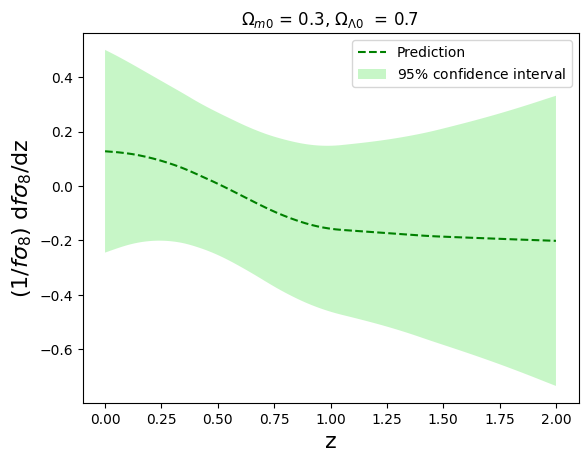

In [47]:
# baixando e nomeando dados
fs8z = np.genfromtxt('/content/drive/MyDrive/Doutorado/Dados/fs8_recon.dat', delimiter='\t')

z_dgapp = fs8z[:, 0]
fs8_dgapp = fs8z[:, 1]

efs8 = fs8z[:, 2]

dfs8z = np.genfromtxt('/content/drive/MyDrive/Doutorado/Dados/dfs8_recon.dat', delimiter='\t')

dfs8 = dfs8z[:, 1]

edfs8 = dfs8z[:, 2]

df_fs8 = dfs8 / fs8_dgapp

sigma_ffs8 = np.sqrt(((df_fs8) ** 2) * (((efs8 / fs8_dgapp) ** 2) + ((edfs8 / dfs8) ** 2)))



# PLOTE
plt.plot(z_dgapp, df_fs8, color='green', label='Prediction', linestyle="--")
plt.fill(np.concatenate([z_dgapp, z_dgapp[::-1]]),
         np.concatenate([df_fs8 - 1.9600 * sigma_ffs8,
                        (df_fs8 + 1.9600 * sigma_ffs8)[::-1]]),
         alpha=.5, fc='lightgreen', ec='None', label='$95\%$ confidence interval')

# legenda, label e título
plt.title('$\Omega_{m0}$ = 0.3, $\Omega_{\Lambda 0}$  = 0.7 ')
plt.xlabel('z', fontsize=16)
plt.ylabel('(1/$f\sigma_8$) d$f\sigma_8$/dz', fontsize=16)
plt.legend(loc='best')
plt.show()

Vamos reconstruir os dados de $H(z)$


Optimized hyperparameters:
theta = [134.94426242   1.98775665]


<ipython-input-48-271e207d8f2e>:41: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "r." (-> color='r'). The keyword argument will take precedence.
  plt.errorbar(x_h, y_h, e, fmt='r.', color='purple', markersize=10, label='Dados')


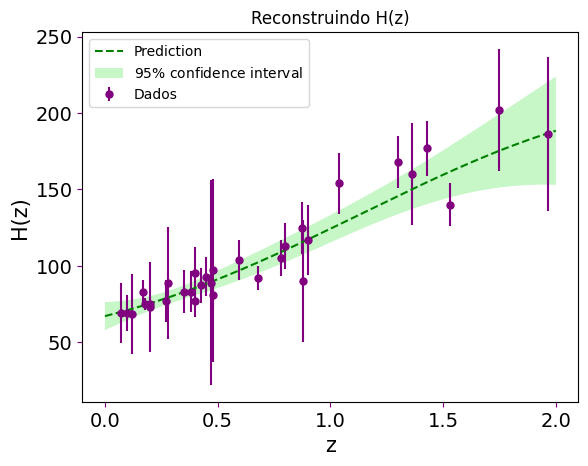

In [48]:
# baixando os dados
data_h = np.genfromtxt('/content/drive/MyDrive/Doutorado/Dados/CC_Hz_data.csv', delimiter=', ')

z_h = data_h[:, 0]

h = data_h[:, 1]

sig_h = data_h[:, 2]

# nomeando
x_h = z_h
y_h = h
e = sig_h

# xmin, xmax and nstar are interpreted as two-dimensional vectors
xmin = 0
xmax = 2.0
nstar = 1000

# initial values of the hyperparameters of the squared-exponential covariance function
initheta = [2.0, 2.0]

# initialization of the Gaussian Process
g = gp.GaussianProcess(x_h, y_h, e, cXstar=(xmin, xmax, nstar))

# training of the hyperparameters and reconstruction of the function
(rec, theta) = g.gp(theta=initheta)

xi = rec[:, 0]

y_pred = rec[:, 1]
sigma  = rec[:, 2]

y_pred_95_less = y_pred - 1.9600*sigma
y_pred_95_plus = y_pred + 1.9600*sigma

# Plot the function, the prediction and the 95% confidence interval
plt.figure()
plt.tick_params(labelsize=14, color='purple')
#plt.plot(z, h_1, color='red', label='$\Lambda$CDM')
plt.errorbar(x_h, y_h, e, fmt='r.', color='purple', markersize=10, label='Dados')
plt.plot(xi, y_pred, color = 'green', label='Prediction', linestyle="--")
plt.fill(np.concatenate([xi, xi[::-1]]),
         np.concatenate([y_pred - 1.9600 * sigma,
                        (y_pred + 1.9600 * sigma)[::-1]]),
         alpha=.5, color = 'lightgreen', ec='None', label=r'$95\%$ confidence interval')

# legenda, label e título
plt.xlabel('z', fontsize=15)
plt.ylabel('H(z)', fontsize=15)
plt.legend(loc='best')
plt.title('Reconstruindo H(z)')
plt.show()

# salvando os dados reconstruídos

H = xi, y_pred, sigma
np.savetxt('hz_recon_2.dat', np.transpose(H), delimiter='\t')
#from google.colab import files
#files.download("hz_recon_2.dat")

Vamos fazer a primeira derivada de H usando o GaPP.


Optimized hyperparameters:
theta = [134.94426242   1.98775665]


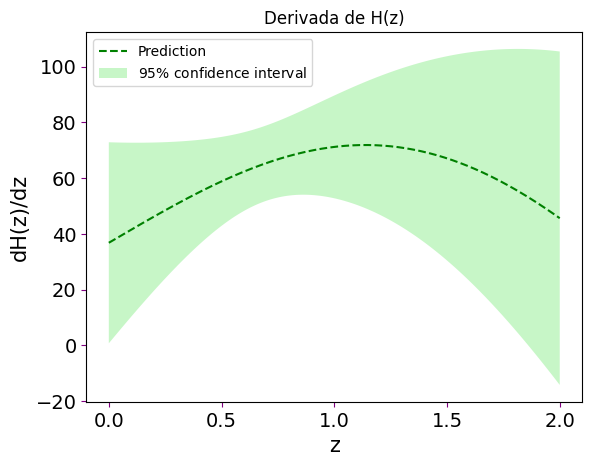

In [49]:
from gapp import dgp # dgp calcula a primeira, segunda e terceira derivada

# baixando os dados reconstruídos de H
data_h = np.genfromtxt('/content/drive/MyDrive/Doutorado/Dados/CC_Hz_data.csv', delimiter=', ')

z_h = data_h[:, 0]

h = data_h[:, 1]

sig_h = data_h[:, 2]

# nomeando
x_h = z_h
y_h = h
e = sig_h

# xmin, xmax and nstar are interpreted as two-dimensional vectors
xmin = 0
xmax = 2.0
nstar = 1000

# initial values of the hyperparameters of the squared-exponential covariance function
initheta = [2.0, 2.0]

# initialization of the Gaussian Process
g = dgp.DGaussianProcess(x_h, y_h, e, cXstar=(xmin, xmax, nstar))

# training of the hyperparameters and reconstruction of the function
(drec, theta) = g.dgp(theta=initheta)

# the second and third derivatives use g.d2gp() and g.d3gp()

xi     = drec[:, 0]
y_pred = drec[:, 1]
sigma  = drec[:, 2]

y_pred_95_less = y_pred - 1.9600*sigma
y_pred_95_plus = y_pred + 1.9600*sigma



# Plot the function, the prediction and the 95% confidence interval
plt.figure()
plt.tick_params(labelsize=14, color='purple')
plt.plot(xi, y_pred, color = 'green', label='Prediction', linestyle="--")
plt.fill(np.concatenate([xi, xi[::-1]]),
         np.concatenate([y_pred - 1.9600 * sigma,
                        (y_pred + 1.9600 * sigma)[::-1]]),
         alpha=.5, color = 'lightgreen', ec='None', label=r'$95\%$ confidence interval')

# legenda, label e título
plt.xlabel('z', fontsize=15)
plt.ylabel('dH(z)/dz', fontsize=15)
plt.legend(loc='best')
plt.title('Derivada de H(z)')
plt.show()

# salvando os dados reconstruídos

dH = xi, y_pred, sigma
np.savetxt('dhz_recon_newz_2.dat', np.transpose(dH), delimiter='\t')
#from google.colab import files
#files.download("dhz_recon_newz_2.dat")

Porém, o que realmente queremos plotar é a razão $\frac{1}{H(z)} \frac{dH}{dz}$.

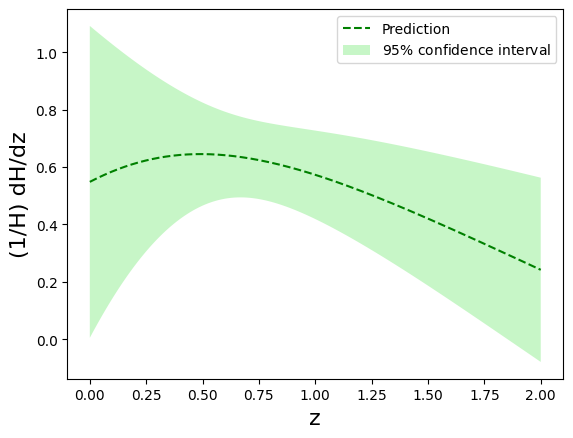

In [50]:
# baixando e nomeando dados reconstruídos de H
hz = np.genfromtxt('/content/drive/MyDrive/Doutorado/Dados/hz_recon_2.dat', delimiter='\t')

z_hz = hz[:, 0]
h_hz = hz[:, 1]

ehz = hz[:, 2]

# baixando e nomeando dados reconstruídos da derivada de H
dhz = np.genfromtxt('/content/drive/MyDrive/Doutorado/Dados/dhz_recon_newz_2.dat', delimiter='\t')

z_dhz = dhz[:, 0]

dh = dhz[:, 1]

edh = dhz[:, 2]

dh_h = dh / h_hz  # H'/H

sigma_H = np.sqrt(((dh_h) ** 2) * (((ehz / h_hz) ** 2) + ((edh / dh) ** 2)))


# PLOTE
plt.plot(z_dhz, dh_h, color='green', label='Prediction', linestyle="--")
#plt.plot(z, dh_1, color='red', label='$\Lambda$CDM')
plt.fill(np.concatenate([z_dhz, z_dhz[::-1]]),
         np.concatenate([dh_h - 1.9600 * sigma_H,
                        (dh_h + 1.9600 * sigma_H)[::-1]]),
         alpha=.5, fc='lightgreen', ec='None', label='$95\%$ confidence interval')

# legenda, label e título
plt.xlabel('z', fontsize=16)
plt.ylabel('(1/H) dH/dz', fontsize=16)
plt.legend(loc='best')
plt.show()

Usaremos o que obtivemos de $H'/H$ para plotar $\frac{\Omega_m '}{\Omega_m}$.

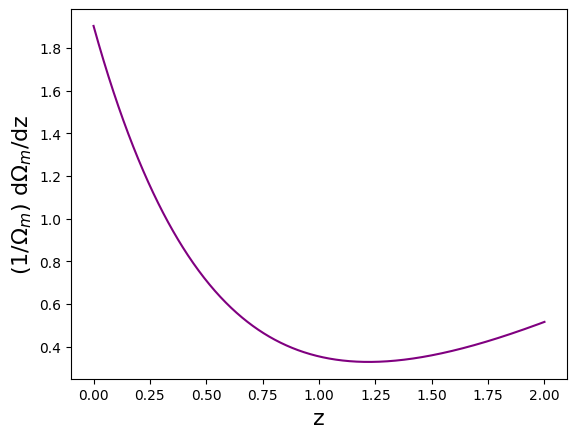

In [51]:
# definindo Om'/Om

dOm_Om = (3/(1+z_dhz)) - (2*dh_h)   #dh_h vem da reconstrução dos dados

eOm = np.sqrt( (2*sigma_H)**2 )

plt.plot(z_dhz, dOm_Om, color='purple')

# legenda, label e título
plt.xlabel('z', fontsize=16)
plt.ylabel('(1/$\Omega_m$) d$\Omega_m$/dz', fontsize=16)
plt.show()

Abaixo, temos os plots referentes ao modelo $\Lambda$CDM.

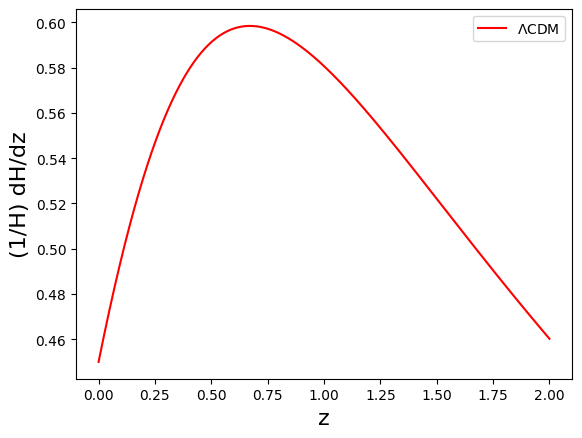

In [52]:
# constantes
Om0 = 0.30
O_L0 = 1 - Om0
h0 = 70 #km/s/Mpc

# MODELO LCDM
cosmo = ccl.Cosmology(
    Omega_c=0.2656, Omega_b=0.0494, w0 = -1, h=0.6727, sigma8=0.8120, n_s=0.9649)


z = np.linspace(0, 2.0, 1000)

# definindo o fator de escala de acordo com o redshift
a = 1/(1+z)

h_1 = h0*(np.sqrt(Om0*((1+z)**3) + O_L0 ))

# derivada de H

dh_lcdm = ( (3/2)*h0*Om0*((1+z)**2) )/(np.sqrt(Om0*((1+z)**3) + O_L0 ))

dh_1 = ( (3/2)*Om0*((1+z)**2) )/(Om0*((1+z)**3) + O_L0 ) # H'/H

# plote

plt.plot(z, dh_1, color='red', label='$\Lambda$CDM')

# legenda, label e título
plt.xlabel('z', fontsize=16)
plt.ylabel('(1/H) dH/dz', fontsize=16)
plt.legend(loc='best')
plt.show()

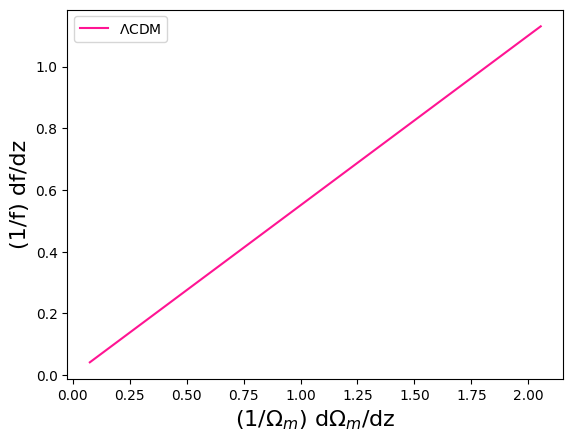

In [53]:
# definindo O_m
Om = (Om0*(a**(-3)))/(Om0*(a**(-3)) + 1 - Om0)
Om0 = 0.315
sigOm0 = 0.007
O_L0 = 1 - Om0
gamma = 0.55

# definindo f conforme linder
f_linder = Om ** gamma

# derivada de f
derivada_flinder = ( (3 * gamma * O_L0)/( (1+z) * (Om0 * ((1+z)**3) + O_L0) ) )  # aqui já é f'/f

# Om'/Om

Omega_m = ccl.background.omega_x(cosmo, a, 'matter')
dOmega_m = np.gradient(Omega_m, z)
dOmega_new = dOmega_m / Omega_m

# PLOTE

plt.plot(dOmega_new, derivada_flinder, color='deeppink', label='$\Lambda$CDM')

# legenda, label e título
plt.xlabel('(1/$\Omega_m$) d$\Omega_m$/dz', fontsize=16)
plt.ylabel('(1/f) df/dz', fontsize=16)
plt.legend()
plt.show()

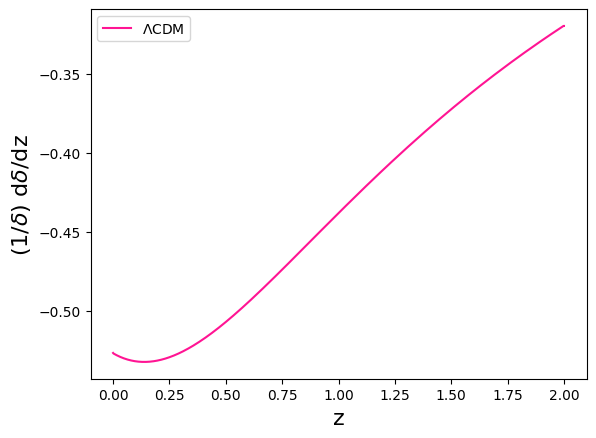

In [54]:
D_lcdm = ccl.growth_factor(cosmo, a)

dD_lcdm = np.gradient(D_lcdm, z)

dD_D_lcdm = dD_lcdm / D_lcdm

plt.plot(z, dD_D_lcdm, color='deeppink', label='$\Lambda$CDM')
plt.xlabel('z', fontsize=16)
plt.ylabel('(1/$\delta$) d$\delta$/dz', fontsize=16)
plt.legend()
plt.show()

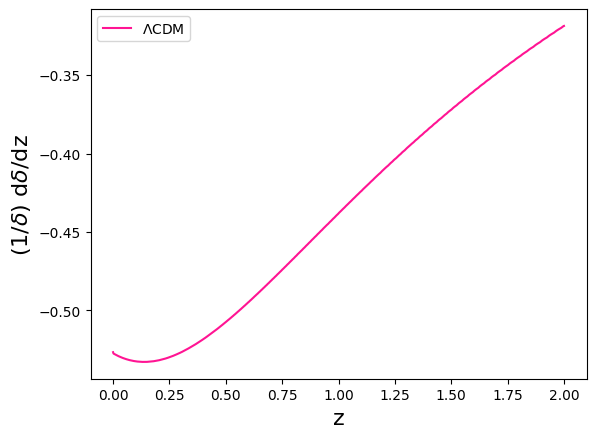

In [55]:
E_lcdm = ccl.background.h_over_h0(cosmo, a)

dE_lcdm = np.gradient(E_lcdm, z)

k_lcdm = (1. + z) / (E_lcdm ** 3)

I_lcdm = 1. - cumtrapz(k_lcdm, x=z, initial=0)

dD_D_lcdm2 = (dE_lcdm / E_lcdm) - (k_lcdm / I_lcdm)

plt.plot(z, dD_D_lcdm2, color='deeppink', label='$\Lambda$CDM')
plt.xlabel('z', fontsize=16)
plt.ylabel('(1/$\delta$) d$\delta$/dz', fontsize=16)
plt.legend()
plt.show()

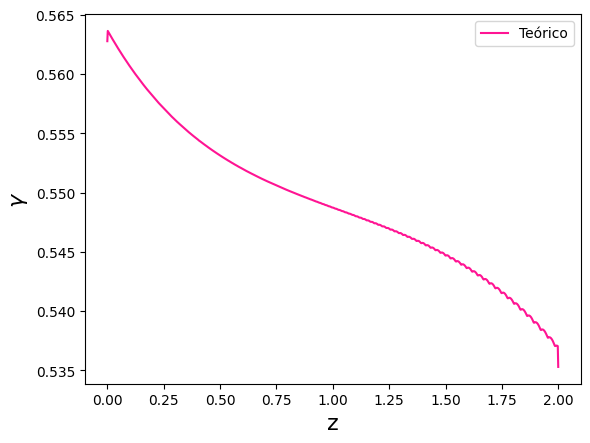

In [56]:
# definindo delta
D_lcdm = ccl.growth_factor(cosmo, a)

dD_lcdm = np.gradient(D_lcdm, z)

dD_D_lcdm = dD_lcdm / D_lcdm



# definindo f conforme linder
#f_linder = Om ** gamma

# derivada de f
#derivada_flinder = ( (3 * gamma * O_L0)/( (1+z) * (Om0 * ((1+z)**3) + O_L0) ) )  # aqui já é f'/f


# definindo f segundo pyccl
f_lcdm = ccl.growth_rate(cosmo, a)


# definindo fsigma8 no lcdm
fs8_teo = ccl.growth_rate(cosmo, a)*0.812*ccl.growth_factor(cosmo, a)

#dfs8_teo = derivada_flinder*0.811*D_lcdm + f_linder*0.811*dD_D_lcdm

dfs8_teo = np.gradient(fs8_teo, z)

dd_fs8_teo = dfs8_teo / fs8_teo


E_lcdm = ccl.background.h_over_h0(cosmo, a)

dE_lcdm = np.gradient(E_lcdm, z)

k_lcdm = (1. + z) / (E_lcdm ** 3)

I_lcdm = 1. - cumtrapz(k_lcdm, x=z, initial=0)

dD_D_lcdm2 = (dE_lcdm / E_lcdm) - (k_lcdm / I_lcdm)  # delta'/delta

dOmega_new1 = 3/(1+z) - (2*(dE_lcdm / E_lcdm))  # Om'/Om


# definindo gamma teórico
gamma_teo = (dd_fs8_teo - dD_D_lcdm2)/dOmega_new1

plt.plot(z, gamma_teo, color='deeppink', label='Teórico')
plt.xlabel('z', fontsize=16)
plt.ylabel('$\gamma$', fontsize=16)
plt.legend()
plt.show()

Agora, vamos usar a reconstrução dos dados de $H$ e $f\sigma_8$ para obter uma curva para $\gamma$, sabendo que:

$\frac{(f\sigma_8)'}{f\sigma_8} = \gamma \frac{\Omega_m'}{\Omega_m} + \frac{E'}{E} - \frac{1+z}{E^3 \left[1 - \int_0^z \frac{1+z' dz'}{E^3(z')} \right]}$.

Sendo:

$E(z) = H(z)/H_0$

Vamos começar reconstruindo $E(z)$.


Optimized hyperparameters:
theta = [1.92758023 1.98752417]


<ipython-input-57-307390503a46>:49: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "r." (-> color='r'). The keyword argument will take precedence.
  plt.errorbar(x_E, y_E, eE, fmt='r.', color='purple', markersize=10, label='Dados')


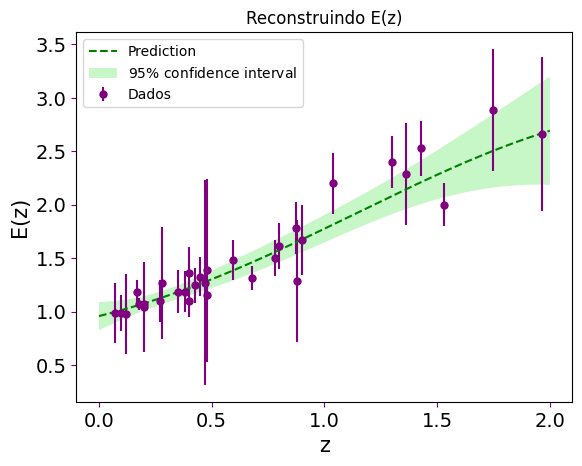

In [57]:
# baixando os dados
data_h = np.genfromtxt('/content/drive/MyDrive/Doutorado/Dados/CC_Hz_data.csv', delimiter=', ')

z_h = data_h[:, 0]

h = data_h[:, 1]

sig_h = data_h[:, 2]

# constantes
h0 = 70 #km/s/Mpc

# E(z)
E_gp = h/h0

sig_Egp = sig_h/h0

# nomeando
x_E = z_h
y_E = E_gp
eE = sig_Egp

# xmin, xmax and nstar are interpreted as two-dimensional vectors
xmin = 0
xmax = 2.0
nstar = 1000

# initial values of the hyperparameters of the squared-exponential covariance function
initheta = [2.0, 2.0]

# initialization of the Gaussian Process
g = gp.GaussianProcess(x_E, y_E, eE, cXstar=(xmin, xmax, nstar))

# training of the hyperparameters and reconstruction of the function
(rec, theta) = g.gp(theta=initheta)

xi = rec[:, 0]

y_pred = rec[:, 1]
sigma  = rec[:, 2]

y_pred_95_less = y_pred - 1.9600*sigma
y_pred_95_plus = y_pred + 1.9600*sigma

# Plot the function, the prediction and the 95% confidence interval
plt.figure()
plt.tick_params(labelsize=14, color='purple')
#plt.plot(z, h_1, color='red', label='$\Lambda$CDM')
plt.errorbar(x_E, y_E, eE, fmt='r.', color='purple', markersize=10, label='Dados')
plt.plot(xi, y_pred, color = 'green', label='Prediction', linestyle="--")
plt.fill(np.concatenate([xi, xi[::-1]]),
         np.concatenate([y_pred - 1.9600 * sigma,
                        (y_pred + 1.9600 * sigma)[::-1]]),
         alpha=.5, color = 'lightgreen', ec='None', label=r'$95\%$ confidence interval')

# legenda, label e título
plt.xlabel('z', fontsize=15)
plt.ylabel('E(z)', fontsize=15)
plt.legend(loc='best')
plt.title('Reconstruindo E(z)')
plt.show()

# salvando os dados reconstruídos

H = xi, y_pred, sigma
np.savetxt('Ez_recon_2.dat', np.transpose(H), delimiter='\t')
#from google.colab import files
#files.download("Ez_recon_2.dat")

Vamos fazer a primeira derivada de E usando o GaPP.


Optimized hyperparameters:
theta = [1.92758023 1.98752417]


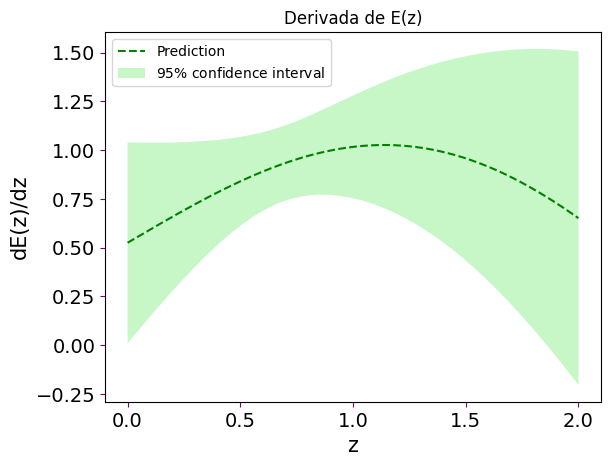

In [58]:
from gapp import dgp # dgp calcula a primeira, segunda e terceira derivada

# baixando os dados reconstruídos de H
data_h = np.genfromtxt('/content/drive/MyDrive/Doutorado/Dados/CC_Hz_data.csv', delimiter=', ')

z_h = data_h[:, 0]

h = data_h[:, 1]

sig_h = data_h[:, 2]

# constantes
h0 = 70 #km/s/Mpc

# E(z)
E_gp = h/h0

sig_Egp = sig_h/h0

# nomeando
x_E = z_h
y_E = E_gp
eE = sig_Egp

# xmin, xmax and nstar are interpreted as two-dimensional vectors
xmin = 0
xmax = 2.0
nstar = 1000

# initial values of the hyperparameters of the squared-exponential covariance function
initheta = [2.0, 2.0]

# initialization of the Gaussian Process
g = dgp.DGaussianProcess(x_E, y_E, eE, cXstar=(xmin, xmax, nstar))

# training of the hyperparameters and reconstruction of the function
(drec, theta) = g.dgp(theta=initheta)

# the second and third derivatives use g.d2gp() and g.d3gp()

xi     = drec[:, 0]
y_pred = drec[:, 1]
sigma  = drec[:, 2]

y_pred_95_less = y_pred - 1.9600*sigma
y_pred_95_plus = y_pred + 1.9600*sigma



# Plot the function, the prediction and the 95% confidence interval
plt.figure()
plt.tick_params(labelsize=14, color='purple')
plt.plot(xi, y_pred, color = 'green', label='Prediction', linestyle="--")
plt.fill(np.concatenate([xi, xi[::-1]]),
         np.concatenate([y_pred - 1.9600 * sigma,
                        (y_pred + 1.9600 * sigma)[::-1]]),
         alpha=.5, color = 'lightgreen', ec='None', label=r'$95\%$ confidence interval')

# legenda, label e título
plt.xlabel('z', fontsize=15)
plt.ylabel('dE(z)/dz', fontsize=15)
plt.legend(loc='best')
plt.title('Derivada de E(z)')
plt.show()

# salvando os dados reconstruídos

dH = xi, y_pred, sigma
np.savetxt('dEz_recon_newz_2.dat', np.transpose(dH), delimiter='\t')
#from google.colab import files
#files.download("dEz_recon_newz_2.dat")

Porém, o que realmente queremos plotar é a razão $\frac{1}{E(z)} \frac{dE}{dz}$.

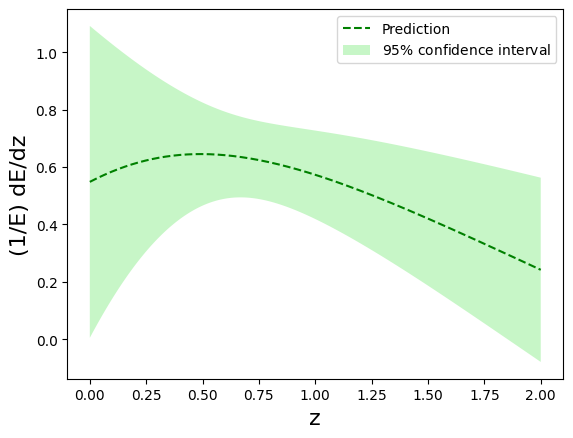

In [59]:
# baixando e nomeando dados reconstruídos de H
Ez = np.genfromtxt('/content/drive/MyDrive/Doutorado/Dados/Ez_recon_2.dat', delimiter='\t')

z_Ez = Ez[:, 0]
E_Ez = Ez[:, 1]

eEz = Ez[:, 2]

# baixando e nomeando dados reconstruídos da derivada de H
dEz = np.genfromtxt('/content/drive/MyDrive/Doutorado/Dados/dEz_recon_newz_2.dat', delimiter='\t')

z_dEz = dEz[:, 0]

dE = dEz[:, 1]

edE = dEz[:, 2]

dE_E = dE / E_Ez  # E'/E

sigma_E = np.sqrt(((dE_E) ** 2) * (((eEz / E_Ez) ** 2) + ((edE / dE) ** 2)))


# PLOTE
plt.plot(z_dEz, dE_E, color='green', label='Prediction', linestyle="--")
#plt.plot(z, dh_1, color='red', label='$\Lambda$CDM')
plt.fill(np.concatenate([z_dEz, z_dEz[::-1]]),
         np.concatenate([dE_E - 1.9600 * sigma_E,
                        (dE_E + 1.9600 * sigma_E)[::-1]]),
         alpha=.5, fc='lightgreen', ec='None', label='$95\%$ confidence interval')

# legenda, label e título
plt.xlabel('z', fontsize=16)
plt.ylabel('(1/E) dE/dz', fontsize=16)
plt.legend(loc='best')
plt.show()

Agora, vamos plotar $\frac{\delta'}{\delta}$:

$\frac{\delta'}{\delta} = \frac{E'}{E} - \frac{1+z}{E^3 \left[1 - \int_0^z \frac{1+z' dz'}{E^3(z')} \right]}$

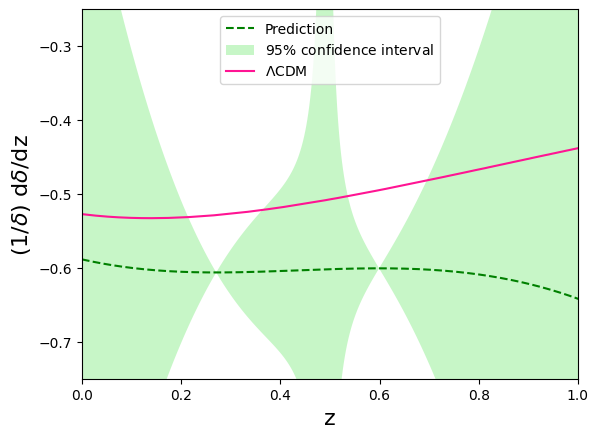

In [60]:
k = (1. + z_Ez) / (E_Ez ** 3)

Int = cumtrapz(k, x=z, initial=0)

I = 1. - Int

T = k/I

#dTdH = ( -3*(1+z_Ez)/((H**4)*Int) - (1+z_Ez)/((H**3)*(Int**2)) )

#dTdI = ( -(1+z_Ez)/((H**3)*(Int**2)) )

#sigInt = ( (1+z_Ez)/H**3 )

#sigT = np.sqrt( (dTdH**2)*(sigma_H**2) + (dTdI**2)*(sigInt**2)*(sigma_H**2) )

dD_D = (dE_E) - T

dDdHH = np.gradient(dD_D, dh_h)

dDdH = np.gradient(dD_D, h_hz)

sigDD = np.sqrt( (dDdHH*sigma_H)**2 + (dDdH*h_hz)**2 )


# PLOTE
plt.plot(z_dEz, dD_D, color='green', label='Prediction', linestyle="--")
#plt.plot(z, dh_1, color='red', label='$\Lambda$CDM')
plt.fill(np.concatenate([z_dEz, z_dEz[::-1]]),
         np.concatenate([dD_D - 1.9600 * sigDD,
                        (dD_D + 1.9600 * sigDD)[::-1]]),
         alpha=.5, fc='lightgreen', ec='None', label='$95\%$ confidence interval')

plt.plot(z, dD_D_lcdm2, color='deeppink', label='$\Lambda$CDM')
plt.xlabel('z', fontsize=16)
plt.xlim(0, 1)
plt.ylim(-0.75,-0.25)
plt.ylabel('(1/$\delta$) d$\delta$/dz', fontsize=16)
plt.legend()
plt.show()

Isolando $\gamma$, o que obtemos é:

$\gamma = \left[ \frac{(f\sigma_8)'}{f\sigma_8} - \frac{\delta'}{\delta} \right] \left( \frac{\Omega_m'}{\Omega_m} \right)^{-1} $.

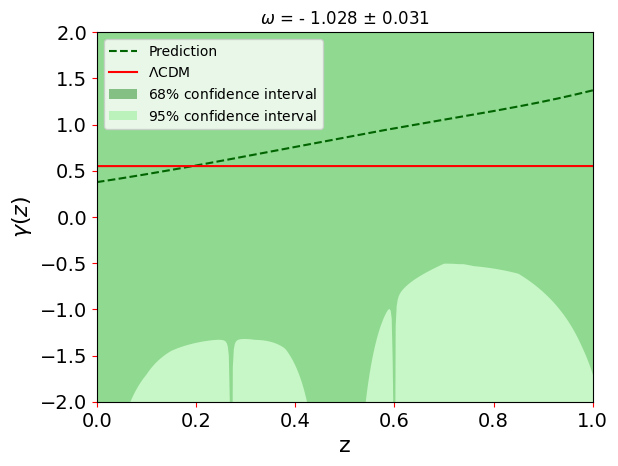

In [64]:
# fsigma8'/fsigma8
df_fs8 = dfs8 / fs8_dgapp

sigma_ffs8 = np.sqrt(((df_fs8) ** 2) * (((efs8 / fs8_dgapp) ** 2) + ((edfs8 / dfs8) ** 2)))

# definindo Om'/Om

dOm_Om = (3/(1+z_dhz)) - (2*dh_h)   #dh_h vem da reconstrução dos dados

eOm = np.sqrt( (2*sigma_H)**2 )


# definindo gamma
gamma_gp = (df_fs8 - dD_D)/(dOm_Om)

sigma_g = np.sqrt( (np.gradient(gamma_gp, df_fs8)*sigma_ffs8)**2 + (np.gradient(gamma_gp, dD_D)*sigDD)**2 + (np.gradient(gamma_gp, dOm_Om)*eOm)**2 )


# gamma LCDM
gamma_lcdm = derivada_flinder / dOmega_new


# PLOTE

fig, ax = plt.subplots()
plt.ylim(-2,2)
plt.xlim(0,1.0)
plt.tick_params(labelsize=14, color='red')
plt.plot(z_dhz, gamma_gp, color='darkgreen', label='Prediction', linestyle="--")
plt.plot(z, gamma_lcdm, color='red', label='$\Lambda$CDM')
plt.fill(np.concatenate([z_dhz, z_dhz[::-1]]),
         np.concatenate([gamma_gp - 1.0000 * sigma_g,
                        (gamma_gp + 1.0000 * sigma_g)[::-1]]),
         alpha=.5, fc='forestgreen', ec='None', label='$68\%$ confidence interval')
plt.fill(np.concatenate([z_dhz, z_dhz[::-1]]),
         np.concatenate([gamma_gp - 1.9600 * sigma_g,
                        (gamma_gp + 1.9600 * sigma_g)[::-1]]),
         alpha=.5, fc='lightgreen', ec='None', label='$95\%$ confidence interval')


# legenda, label e título
plt.xlabel('z', fontsize=16)
plt.ylabel('$\gamma(z)$', fontsize=16)
plt.legend(loc='best')
#plt.savefig('gamma_cte.pdf')
plt.title('$\omega$ = - 1.028 $\pm$ 0.031')
plt.show()